In [37]:
#load predictions
import os
import h5py
import numpy as np
from meld_classifier.meld_cohort import MeldCohort, MeldSubject


Setting MELD_DATA_PATH to /rds/user/kw350/rds-kw350-meld/meld_data/Data/
Setting BASE_PATH to /rds/user/kw350/rds-kw350-meld/meld_data/Data/
Setting EXPERIMENT_PATH to /rds/user/kw350/rds-kw350-meld/experiments/kw350/
No fs_subjects_path defined in /home/kw350/software/gdl/meld_classifier/meld_config.ini!


In [41]:
predictions_file_1 = os.path.join('/rds/project/kw350',
             'rds-kw350-meld/experiments',
             'co-ripa1/iteration_21-09-15/ensemble_21-09-15',
             'fold_all/results/',
             'predictions_ensemble_iteration.hdf5')

predictions_file_2 = os.path.join('/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1',
                                       'iteration_21-09-17/ensemble_21-09-20/fold_all/',
                                       'results','predictions_ensemble_iteration.hdf5')

In [33]:
def load_prediction(subject,hdf5):
    results={}
    with h5py.File(hdf5, "r") as f:
        for hemi in ['lh','rh']:
            results[hemi] = f[subject][hemi]['prediction'][:]
    return results

In [49]:
with h5py.File(predictions_file_1, "r") as f:
    subjects1 = list(f.keys())
with h5py.File(predictions_file_2, "r") as f:
    subjects2 = list(f.keys())    
    
subjects = np.unique(subjects1+subjects2)
subjects[0]

'MELD2_H7_3T_FCD_001'

In [39]:
c = MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_6.hdf5',
               dataset='MELD_dataset_V6.csv')


In [100]:
results = []
features=[]
for si,subject in enumerate(subjects):
    if si%100==0:
        print(si/len(subjects))
    try:
        hdf_predictions = os.path.join('/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1',
                                       'iteration_21-09-15/ensemble_21-09-15/fold_all/',
                                       'results','predictions_ensemble_iteration.hdf5')
        result_hemis = load_prediction(subject,hdf_predictions)
    except KeyError:
        hdf_predictions = os.path.join('/rds/project/kw350/rds-kw350-meld/experiments/co-ripa1',
                                       'iteration_21-09-17/ensemble_21-09-20/fold_all/',
                                       'results','predictions_ensemble_iteration.hdf5')
        result_hemis = load_prediction(subject,hdf_predictions)
    labels_hemis = {}
    
    subj = MeldSubject(subject,cohort=c)
    detected = False
    tp=0
    fp=0
    fn=0
    tn=0
    for hemi in ['lh','rh']:
        _, labels_hemis[hemi] = subj.load_feature_lesion_data(
            features, hemi=hemi, features_to_ignore=[]
        )
        tp += np.logical_and(labels_hemis[hemi][c.cortex_mask],result_hemis[hemi]).sum()
        detected += tp>0
        fp += np.logical_and(result_hemis[hemi], ~labels_hemis[hemi][c.cortex_mask]).sum()
        fn += np.logical_and(~result_hemis[hemi], labels_hemis[hemi][c.cortex_mask]).sum()
        tn += np.logical_and(~result_hemis[hemi], ~labels_hemis[hemi][c.cortex_mask]).sum()
    
    dice_lesion = np.nan_to_num((2*tp)/(2*tp+fn+fp))
    dice_nonlesion = (2*tn)/(2*tn+fn+fp)
    results.append([subject,subj.is_patient,
                    detected,tp,fn,fp,tn,dice_lesion,dice_nonlesion])

0.0


/tmp/ipykernel_182058/304668961.py:34: RuntimeWarning: invalid value encountered in long_scalars
  dice_lesion = np.nan_to_num((2*tp)/(2*tp+fn+fp))


0.10976948408342481
0.21953896816684962
0.32930845225027444
0.43907793633369924
0.5488474204171241
0.6586169045005489
0.7683863885839737
0.8781558726673985
0.9879253567508233


In [104]:
import pandas as pd

In [105]:
df=pd.DataFrame(results,columns=['Subject ID','Group','Detected','TP','FN','FP','TN','Dice_lesion','Dice_nonlesion'])

In [113]:
np.mean(df[df.Group]['Dice_lesion'])

0.14114419608257986

Text(0.5, 0, 'Dice lesion')

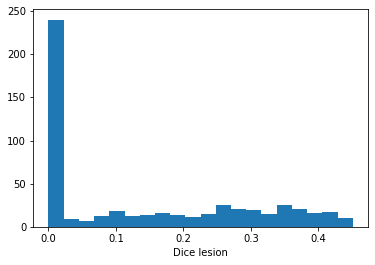

In [115]:
import matplotlib.pyplot as plt
plt.hist(df[df.Group]['Dice_lesion'],20);
plt.xlabel('Dice lesion')